# Summer analysis 2023: ndvi+ndmi+marginalization res 10

This notebook joins ndvi (res10), ndmi (res10) and marginalization (res8 to res10 through centroids) and creates categories for NDVI and marg in order to create the following analysis:

Analysis 1: Average min, mean, max data by marginalization group
Min, mean and max ndvi and ndmi is calculated by marginalization group.

Analisis 2: Zones that may recieve irrigation within urban spaces and its relation with marginalization
Places without vegetation are discarted. (ndvi without locations with water, marshy surfaces, artificial structures, rocks adn clouds)
10% max and 10% min ndmi_diff are located, ploted and exported to csv.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
city = 'Monterrey'

In [3]:
csv_dataset = True
save_plots = False

## Data download

Data download - NDVI

In [4]:
# Downloading NDVI res 10 data
ndvi_schema = 'raster_analysis'
ndvi_folder = 'ndvi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndvi_schema}.{ndvi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndvi_res10.shape)
ndvi_res10.head(2)

(75705, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8a48a20e58c7fff,"POLYGON ((-100.25628 25.71663, -100.25560 25.7...",10,0.178634,0.085051,0.197787,0.266311,0.033497,0.232814,-0.002244,Monterrey
1,8a48a20e596ffff,"POLYGON ((-100.26159 25.71180, -100.26091 25.7...",10,0.054997,0.031887,0.054372,0.088824,-0.003849,0.092673,-0.000919,Monterrey


Data download - NDMI

In [5]:
# Downloading NDMI res 10 data
ndmi_schema = 'raster_analysis'
ndmi_folder = 'ndmi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndmi_schema}.{ndmi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndmi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndmi_res10.shape)
ndmi_res10.head(2)

(75705, 11)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,city
0,8a48a20e136ffff,"POLYGON ((-100.25983 25.75116, -100.25915 25.7...",10,-0.001140,0.080293,-0.019805,0.160764,-0.043485,0.204249,0.000001,Monterrey
1,8a48a20e1307fff,"POLYGON ((-100.25539 25.74921, -100.25471 25.7...",10,-0.009907,0.084443,-0.029270,0.157721,-0.057984,0.215705,-0.000076,Monterrey


Data download - Municipalities (in order to download marginalization)

In [6]:
mun_schema = 'metropolis'
mun_table = 'metro_gdf'

query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(18, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,19001,19,001,Abasolo,"POLYGON ((-100.39267 25.98715, -100.39224 25.9...",Monterrey
1,19006,19,006,Apodaca,"POLYGON ((-100.24794 25.86462, -100.24672 25.8...",Monterrey


Data download - Marginalization

In [7]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())
cvegeo_list

['19001',
 '19006',
 '19009',
 '19010',
 '19012',
 '19018',
 '19019',
 '19021',
 '19025',
 '19026',
 '19031',
 '19039',
 '19041',
 '19045',
 '19046',
 '19047',
 '19048',
 '19049']

In [8]:
# donwload hexagons with marg data
hex_marg = gpd.GeoDataFrame()
marg_table = 'hex_bins_marg_2020'
marg_schema = 'censo'


# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {marg_schema}.{marg_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_marg = pd.concat([hex_marg, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_marg.shape)
hex_marg.head(2)

(1463, 17)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,"POLYGON ((-100.38026 25.93877, -100.38069 25.9...",8848a23881fffff,19001,250.11478,1.507139,6.775771,0.155156,0.077578,0.077578,0.077578,0.0,0.659412,15.438009,1.512770,9.580874,123.461212,0.964433
1,"POLYGON ((-100.38588 25.94625, -100.38631 25.9...",8848a23883fffff,19001,487.42150,3.485196,33.948074,3.441633,0.081661,0.081661,0.081661,0.0,1.016450,87.389890,8.739015,55.745712,123.066629,0.961350


## Data treatment

### Data treatment - Bring marginalization data (res8) to ndvi (res10)

Find ndvi centroids in order to intersect res10 info with a single res8 hex

In [9]:
#Find centroids
ndvi_res10_calc = ndvi_res10.to_crs("EPSG:6372")
centroids = ndvi_res10_calc.centroid
centroids = centroids.to_crs("EPSG:4326")

#Turn into gdf
centroids_gdf = gpd.GeoDataFrame(centroids)
centroids_gdf = centroids_gdf.rename(columns={0:'geometry'})

#Review result
print(centroids_gdf.shape)
centroids_gdf.head(2)

(75705, 1)


,geometry
0,POINT (-100.25634 25.71737)
1,POINT (-100.26165 25.71254)


Intersect centroids with orginal ndvi data to keep hex_id data

In [10]:
centroids_hexid = gpd.overlay(centroids_gdf,ndvi_res10,keep_geom_type=True)

columns_tokeep = ['hex_id','geometry']
centroids_hexid = centroids_hexid[columns_tokeep]

#Review result
print(centroids_hexid.shape)
centroids_hexid.head(2)

(75705, 2)


,hex_id,geometry
0,8a48a20e58c7fff,POINT (-100.25634 25.71737)
1,8a48a20e596ffff,POINT (-100.26165 25.71254)


Intersect centroids with marginalization data

In [11]:
centroids_marg = gpd.overlay(centroids_hexid,hex_marg,keep_geom_type=True)

columns_tokeep = ['hex_id','pobtot','im_2020','imn_2020']
centroids_marg = centroids_marg[columns_tokeep]

#Review result
print(centroids_marg.shape)
centroids_marg.head(2)

(71687, 4)


,hex_id,pobtot,im_2020,imn_2020
0,8a48a20e58c7fff,10180.852,123.090448,0.961536
1,8a48a20e596ffff,10180.852,123.090448,0.961536


Merge centroids_marg back with res10 geometry

In [12]:
ndvi_marg = pd.merge(ndvi_res10,centroids_marg, on='hex_id')

#Review result
print(ndvi_marg.shape)
ndvi_marg.head(2)

(71687, 14)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,pobtot,im_2020,imn_2020
0,8a48a20e58c7fff,"POLYGON ((-100.25628 25.71663, -100.25560 25.7...",10,0.178634,0.085051,0.197787,0.266311,0.033497,0.232814,-0.002244,Monterrey,10180.852,123.090448,0.961536
1,8a48a20e596ffff,"POLYGON ((-100.26159 25.71180, -100.26091 25.7...",10,0.054997,0.031887,0.054372,0.088824,-0.003849,0.092673,-0.000919,Monterrey,10180.852,123.090448,0.961536


### Data treatment - Merge NDVI_MARG with NDMI

In [13]:
ndmi_res10_clean = ndmi_res10.drop(columns=['geometry','res','city'])
ndvi_ndmi_marg = ndvi_marg.merge(ndmi_res10_clean, left_on='hex_id', right_on='hex_id')

#Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(71687, 21)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,pobtot,im_2020,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend
0,8a48a20e58c7fff,"POLYGON ((-100.25628 25.71663, -100.25560 25.7...",10,0.178634,0.085051,0.197787,0.266311,0.033497,0.232814,-0.002244,...,10180.852,123.090448,0.961536,0.037206,0.080615,0.024421,0.188359,-0.024711,0.213071,-0.000861
1,8a48a20e596ffff,"POLYGON ((-100.26159 25.71180, -100.26091 25.7...",10,0.054997,0.031887,0.054372,0.088824,-0.003849,0.092673,-0.000919,...,10180.852,123.090448,0.961536,0.006685,0.082761,-0.009015,0.166920,-0.040795,0.207715,-0.000125


### Data treatment - Create data categories

Data treatment - Creating vegetation categories

In [14]:
# Creating vegetation categories
ndvi_ndmi_marg['ndvi_median_rango'] = np.nan
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.4 )&
             (ndvi_ndmi_marg.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.2)&
             (ndvi_ndmi_marg.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.1)&
             (ndvi_ndmi_marg.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'

# Ordering data
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_ndmi_marg['ndvi_median_rango'] = pd.Categorical(ndvi_ndmi_marg['ndvi_median_rango'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(71687, 22)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,im_2020,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango
0,8a48a20e58c7fff,"POLYGON ((-100.25628 25.71663, -100.25560 25.7...",10,0.178634,0.085051,0.197787,0.266311,0.033497,0.232814,-0.002244,...,123.090448,0.961536,0.037206,0.080615,0.024421,0.188359,-0.024711,0.213071,-0.000861,Suelo
1,8a48a20e596ffff,"POLYGON ((-100.26159 25.71180, -100.26091 25.7...",10,0.054997,0.031887,0.054372,0.088824,-0.003849,0.092673,-0.000919,...,123.090448,0.961536,0.006685,0.082761,-0.009015,0.166920,-0.040795,0.207715,-0.000125,Suelo artificial/Agua/Piedra


Data treatment - Creating marginalization categories

In [15]:
ndvi_ndmi_marg['Grado_Marg'] = np.nan
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.imn_2020>=0.966338 , 'Grado_Marg'] = 'Muy bajo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.946436 )&
             (ndvi_ndmi_marg.imn_2020<0.966338), 'Grado_Marg'] = 'Bajo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.926536)&
             (ndvi_ndmi_marg.imn_2020<0.946436), 'Grado_Marg'] = 'Medio'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.8999)&
             (ndvi_ndmi_marg.imn_2020<0.926536), 'Grado_Marg'] = 'Alto'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020<0.8999), 'Grado_Marg'] = 'Muy Alto'

categories = ['Muy Alto', 'Alto', 'Medio', 'Bajo', 'Muy bajo']
ndvi_ndmi_marg['Grado_Marg'] = pd.Categorical(ndvi_ndmi_marg['Grado_Marg'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(71687, 23)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg
0,8a48a20e58c7fff,"POLYGON ((-100.25628 25.71663, -100.25560 25.7...",10,0.178634,0.085051,0.197787,0.266311,0.033497,0.232814,-0.002244,...,0.961536,0.037206,0.080615,0.024421,0.188359,-0.024711,0.213071,-0.000861,Suelo,Bajo
1,8a48a20e596ffff,"POLYGON ((-100.26159 25.71180, -100.26091 25.7...",10,0.054997,0.031887,0.054372,0.088824,-0.003849,0.092673,-0.000919,...,0.961536,0.006685,0.082761,-0.009015,0.166920,-0.040795,0.207715,-0.000125,Suelo artificial/Agua/Piedra,Bajo


## Data analysis 1 - Average min, mean, max data by marginalization group

In [16]:
marginalization_behaviour = ndvi_ndmi_marg.groupby('Grado_Marg').agg({'ndvi_min':np.mean,'ndvi_mean':np.mean,'ndvi_max':np.mean,
                                                                      'ndmi_min':np.mean,'ndmi_mean':np.mean,'ndmi_max':np.mean})
marginalization_behaviour

,ndvi_min,ndvi_mean,ndvi_max,ndmi_min,ndmi_mean,ndmi_max
Grado_Marg,,,,,,
Muy Alto,0.039999,0.209018,0.376208,-0.108660,-0.009527,0.165715
Alto,0.037491,0.279495,0.470924,-0.104079,0.021025,0.211836
Medio,0.045605,0.228938,0.377378,-0.084530,0.014559,0.193175
Bajo,0.038042,0.207576,0.342798,-0.084312,0.010229,0.190418
Muy bajo,0.039758,0.212049,0.341964,-0.061363,0.028665,0.198022


In [35]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = marginalization_behaviour.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../data/external/averagerasterdata_bymarg_{}.csv".format(city.lower()))

(5, 6)


## Data analysis 2 - Zones that may recieve irrigation within urban spaces and its relation with marginalization

### Data treatment - Filter vegetation and plot ndmi_diff

NDVI filtering for places with vegetation

In [18]:
#Keeping High-moderate-minimal vegetation density
data_withveg = ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median_rango == 'Alta densidad vegetal') |
                   (ndvi_ndmi_marg.ndvi_median_rango == 'Moderada densidad vegetal')|
                   (ndvi_ndmi_marg.ndvi_median_rango == 'Mínima densidad vegetal')]

#Reviewing process
print(data_withveg.shape)
data_withveg.head(2)

(31753, 23)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg
86,8a48a205259ffff,"POLYGON ((-100.25996 25.73545, -100.25929 25.7...",10,0.216032,0.087938,0.228317,0.330766,0.055507,0.27526,-0.001636,...,0.975296,0.037873,0.082079,0.029490,0.20319,-0.038773,0.241963,-0.000157,Mínima densidad vegetal,Muy bajo
90,8a48a2052597fff,"POLYGON ((-100.25916 25.73438, -100.25848 25.7...",10,0.377004,0.183357,0.394016,0.584053,0.091933,0.49212,-0.004976,...,0.975296,0.086176,0.103218,0.081533,0.26498,-0.029909,0.294889,-0.001726,Mínima densidad vegetal,Muy bajo


Visual correlation analyisis

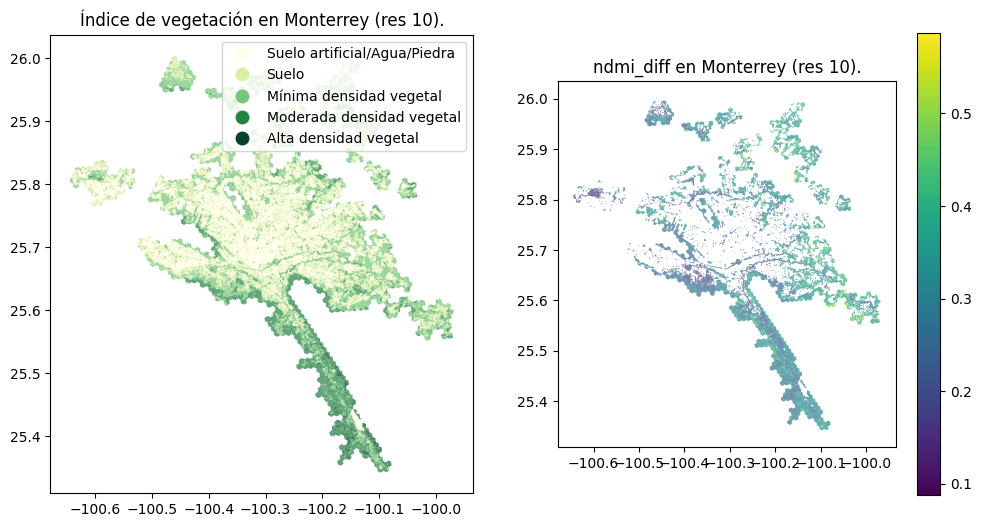

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ndvi_ndmi_marg.plot('ndvi_median_rango', 'YlGn', ax=ax[0], legend=True)
data_withveg.plot('ndmi_diff', 'viridis', ax=ax[1], legend=True)

ax[0].set_title('Índice de vegetación en {} (res {}).'.format(city,res))
ax[1].set_title('ndmi_diff en {} (res 10).'.format(city))

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmidiff_{}.svg".format(city.lower(),city.lower()))

### Data treatment - Find mins and maxs ndmi_diff

Find 10% mins and 10% maxs

In [24]:
# Finding len of 10% of data
tenpercent = int(len(ndvi_ndmi_marg)/10)

#Finding smallest and largest ndmi_diff
ndmi_diff_mins = data_withveg.nsmallest(tenpercent,'ndmi_diff')
ndmi_diff_maxs = data_withveg.nlargest(tenpercent,'ndmi_diff')

Create category

In [25]:
ndmi_diff_mins['ndmi_diff_cat'] = '10%_mins'
ndmi_diff_maxs['ndmi_diff_cat'] = '10%_maxs'

ndmi_diff_extremes = pd.concat([ndmi_diff_mins, ndmi_diff_maxs])

print(ndmi_diff_extremes.shape)
ndmi_diff_extremes.head(2)

(14336, 24)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg,ndmi_diff_cat
46975,8a48a232d487fff,"POLYGON ((-100.59590 25.80956, -100.59522 25.8...",10,0.191708,0.073744,0.204331,0.262959,0.058688,0.204271,-0.001639,...,0.018330,0.029099,0.014346,0.067211,-0.020528,0.087739,-0.000407,Mínima densidad vegetal,Bajo,10%_mins
47591,8a48a2328867fff,"POLYGON ((-100.59306 25.80975, -100.59238 25.8...",10,0.277845,0.099322,0.317461,0.358961,0.088346,0.270615,-0.001141,...,0.053009,0.032399,0.049802,0.092337,0.004366,0.087971,-0.000991,Mínima densidad vegetal,Bajo,10%_mins


Plot data to get a visual

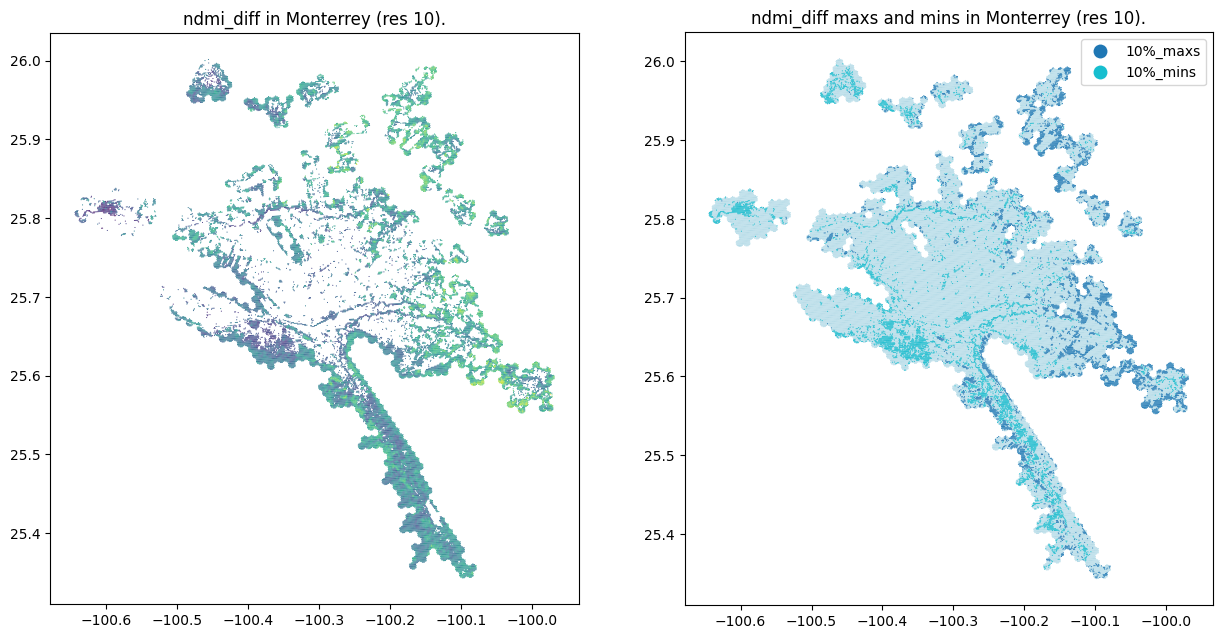

In [26]:
#Create figure
fig,ax = plt.subplots(1,2,figsize=(15,20))

#--------- First ax ---------
#Plotting ndmi_diff
data_withveg.plot('ndmi_diff', 'viridis', ax=ax[0], zorder = 0)

#Format
ax[0].set_title('ndmi_diff in {} (res 10).'.format(city))

#--------- Second ax ---------
#Plotting ndmi_diff maxs and mins
ndmi_diff_extremes.plot('ndmi_diff_cat',ax=ax[1],zorder = 2, legend=True)
ndvi_ndmi_marg.plot(color = 'lightblue',ax=ax[1], zorder = 0)

#Format
ax[1].set_title('ndmi_diff maxs and mins in {} (res 10).'.format(city))

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmidiff_minsandmaxs_{}.svg".format(city.lower(),city.lower()))

### Data analysis - Clean data and export to csv

Clean gdf

In [27]:
columns_tokeep = ['hex_id','res','ndmi_diff','ndmi_diff_cat','im_2020','imn_2020','Grado_Marg','city','geometry']
ndmi_diff_extremes_c = ndmi_diff_extremes[columns_tokeep]
                  
#Review result
print(ndmi_diff_extremes_c.shape)
ndmi_diff_extremes_c.head(2)

(14336, 9)


,hex_id,res,ndmi_diff,ndmi_diff_cat,im_2020,imn_2020,Grado_Marg,city,geometry
46975,8a48a232d487fff,10,0.087739,10%_mins,121.271892,0.947331,Bajo,Monterrey,"POLYGON ((-100.59590 25.80956, -100.59522 25.8..."
47591,8a48a2328867fff,10,0.087971,10%_mins,122.542784,0.957258,Bajo,Monterrey,"POLYGON ((-100.59306 25.80975, -100.59238 25.8..."


Data linear transformation in order to produce desired 3D map

In [28]:
#Linear intepolation data
x1 = ndmi_diff_extremes_c['ndmi_diff'].max()
y1 = ndmi_diff_extremes_c['ndmi_diff'].min()

x2 = ndmi_diff_extremes_c['ndmi_diff'].min()
y2 = ndmi_diff_extremes_c['ndmi_diff'].max()

m = (y2-y1)/(x2-x1)
b = y1-m*x1

# Convert all ndmi_diff to its opossite value in that linear interpolation (y=mx+b)
ndmi_diff_extremes_c['ndmi_diff_opossite'] = ndmi_diff_extremes_c['ndmi_diff'].apply(lambda x: m*x+b)

#Review result
print(ndmi_diff_extremes_c.shape)
ndmi_diff_extremes_c.head(2)

(14336, 10)


/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,hex_id,res,ndmi_diff,ndmi_diff_cat,im_2020,imn_2020,Grado_Marg,city,geometry,ndmi_diff_opossite
46975,8a48a232d487fff,10,0.087739,10%_mins,121.271892,0.947331,Bajo,Monterrey,"POLYGON ((-100.59590 25.80956, -100.59522 25.8...",0.586953
47591,8a48a2328867fff,10,0.087971,10%_mins,122.542784,0.957258,Bajo,Monterrey,"POLYGON ((-100.59306 25.80975, -100.59238 25.8...",0.586721


Export to csv

In [34]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = ndmi_diff_extremes_c.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../data/external/ndmi_diff_marg_{}.csv".format(city.lower()))

(14336, 10)
